<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Not needed before we upload files to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Get python files and augmented data

In [ ]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving best_samples_weight_full.pt to best_samples_weight_full.pt
Saving best_samples_weight_subset.pt to best_samples_weight_subset.pt
Saving compute_mean_std.py to compute_mean_std.py
Saving Dataload.py to Dataload.py
Saving F1_test.py to F1_test.py
Saving image_sizes.py to image_sizes.py
Saving kaggle.json to kaggle.json
Saving main.py to main.py
Saving main_notebook.ipynb to main_notebook.ipynb
Saving main_notebook_rosa.ipynb to main_notebook_rosa.ipynb
Saving metrics.py to metrics.py
Saving metrics_each_class.py to metrics_each_class.py
Saving models.py to models.py
Saving NEW_weighted_sampler.py to NEW_weighted_sampler.py
Saving norm_samples_weight_full.pt to norm_samples_weight_full.pt
Saving norm_samples_weight_subset.pt to norm_samples_weight_subset.pt
Saving README.md to README.md
Saving requirements.txt to requirements.txt
Saving rnn_test.ipynb to rnn_test.ipynb
Saving samples_weight.pt to samples_weight.pt
Saving samples_weight_subset.pt to samples_weight_subset.pt
Saving s

Get data from kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

 99% 396M/399M [00:00<00:00, 1.38GB/s]
100% 399M/399M [00:00<00:00, 1.38GB/s]


Defining model arcitechture - A CNN similar to AlexNet

In [ ]:
# Model arcitechture
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define convolutional kernels and number of kernels in each layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=8, stride=4, padding=0)
        self.conv2 = nn.Conv2d(64,128, 5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128,192, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(192,192,3, stride=1,padding=1)
        self.conv5 = nn.Conv2d(192,128,3, stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(3,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.pool3 = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(16*2*2)
        self.bn2 = nn.BatchNorm2d(32*2*2)
        self.bn3 = nn.BatchNorm2d(192)
        self.bn4 = nn.BatchNorm2d(192)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm1d(150)
        self.bn7 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608,150)
        self.fc2 = nn.Linear(150,64)
        self.fc3 = nn.Linear(64,18)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        #x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        #x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout3(x)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn7(self.fc2(x)))
        logits = self.fc3(x)
        return logits

Setup dataloaders and initialize model

In [51]:
# Loading relevant packages
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler
import numpy as np
from tqdm import tqdm
import shutil
import zipfile
# Custom made modules
from Dataload import pil_process_image_color, encode, Dataset, CustomImageDataset
from utils import train_network, pos_weight, test
from metrics import compute_metrics

# Hyperparameters
batch_size = 64
lr = 0.003
weight_decay = 0
INPUT_HEIGHT = 256
INPUT_WIDTH = 256

# Techniques for handling class imbalance
Normalize_weights = True # To use normalized class weights or not
use_weighted_sampler = False # To use weighted sampling or not
use_weighted_loss = False # To use weighed loss function or not
aug_all = False #augment all or add more augmentation to non-class 1 datapoints

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'
FILENAME_TRAIN_AUG = 'train_aug.csv' # augmented data for training

# Unzip extra data
# zip_path= DATASET_PATH + "SUBSET_augmented_images.zip"
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall("data/")
# zip_path= DATASET_PATH + "FULL_augmented_images.zip"

my_dir = r"/content/Dataset/COMP5329S1A2Dataset/data/"
my_zip = r"/content/Dataset/COMP5329S1A2Dataset/FULL_augmented_images.zip"

with zipfile.ZipFile(my_zip) as zip_file:
    for member in zip_file.namelist():
        filename = os.path.basename(member)
        # skip directories
        if not filename:
            continue

        # copy file (taken from zipfile's extract)
        source = zip_file.open(member)
        target = open(os.path.join(my_dir, filename), "wb")
        with source, target:
            shutil.copyfileobj(source, target)


with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")
df_train_bigger = pd.read_csv("/content/Dataset/COMP5329S1A2Dataset/train_aug.csv")

# Defining transforms
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # For resizing images to square

# Data augmentation
trainTransforms_augment = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.RandomAffine(degrees=30),
     transforms.ColorJitter(),transforms.RandomCrop(size=256,pad_if_needed=True),
     transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])

if aug_all:
    trainTransforms_basic = trainTransforms_augment
else:
# Transform to use on common class
  trainTransforms_basic = transforms.Compose(
      [resize,transforms.ColorJitter(),transforms.RandomCrop(size=256,pad_if_needed=True),
     transforms.ToTensor()
      ,transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])
      #AddGaussianNoise(mean=0., std=0.1)])

# Transform for test images
testTransforms = transforms.Compose([resize,transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4652, 0.4492, 0.4214], std=[0.2317, 0.2265, 0.2303])])

# Sampling method
if Normalize_weights:
  # Calculate weights for loss function
  c_weights = pos_weight(df_train,barplot=False,normalize=True)
  samples_weight = torch.load("/content/norm_samples_weight_full.pt") # Sample common class less
else:
  c_weights = pos_weight(df_train,barplot=False,normalize=False)
  samples_weight = torch.load("/content/unnorm_samples_weight_full.pt") # Sample common class less

weighted_sampler_full = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create dataloaders
training_data = CustomImageDataset(df_train_bigger,DATASET_PATH+"data/",transform=trainTransforms_basic,transform_aug=trainTransforms_augment,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
if use_weighted_sampler:
  train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=weighted_sampler_full)
else:
  train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_data,shuffle=False)

# Setup model
model = CNN().to(device)

# Use BCE loss
if use_weighted_loss:
  loss = torch.nn.BCEWithLogitsLoss(c_weights.to(device))
else:
  loss = torch.nn.BCEWithLogitsLoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print('Model initialized.')

We are using GPU.
Class counts: tensor([22794.,  1162.,  4364.,  1272.,  1130.,  1394.,  1221.,  2210.,  1042.,
         1471.,   604.,   605.,   251.,  1934.,  1099.,  1430.,  1525.,  1020.],
       dtype=torch.float64)
Class weights: tensor([0.0110, 0.2160, 0.0575, 0.1973, 0.2221, 0.1801, 0.2056, 0.1136, 0.2409,
        0.1706, 0.4156, 0.4149, 1.0000, 0.1298, 0.2284, 0.1755, 0.1646, 0.2461],
       dtype=torch.float64)
Model initialized.


Training on subset of all data and compute metrics for validation set

In [49]:
# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")

# Loading sample weights to sample some classes more than others

if Normalize_weights:
  samples_weight_subset = torch.load("/content/norm_samples_weight_subset.pt")
else:
  samples_weight_subset = torch.load("/content/unnorm_samples_weight_subset.pt") # Sample common class less

weigthed_sampler_subset = WeightedRandomSampler(samples_weight_subset,len(samples_weight_subset))

# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
if use_weighted_sampler:
  subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size,sampler=weigthed_sampler_subset)
else:
  subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size,shuffle=True)

validation_loader = DataLoader(validation_dataset, shuffle=False)

# Training
log_interval = 50 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=10)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Set thresholds for predictions
thresholds = [0.5]*18

# Testing on validation set and compute metrics
print("With prediction_all = True:")
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True,predict_all=True) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
#for label in range(1,19): # remember that 12 is deleted!
#   print("Metrics for class {}".format(label))
#   print(compute_metrics(all_preds.squeeze()[:,label-1],all_targets.squeeze()[:,label-1]))
print("Full Metrics")
print(compute_metrics(all_preds,all_targets))

# print("With prediction_all = False:")
# test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True,predict_all=False) # output predictions as tensors
# all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
# all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
# print("Full Metrics")
# print(compute_metrics(all_preds,all_targets))

  0%|          | 0/10 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.759397

Train Epoch: 0 [3200/23996 (13%)]	Loss: 0.181407

Train Epoch: 0 [6400/23996 (27%)]	Loss: 0.180577

Train Epoch: 0 [9600/23996 (40%)]	Loss: 0.177570

Train Epoch: 0 [12800/23996 (53%)]	Loss: 0.177348

Train Epoch: 0 [16000/23996 (67%)]	Loss: 0.138144

Train Epoch: 0 [19200/23996 (80%)]	Loss: 0.194618

Train Epoch: 0 [22400/23996 (93%)]	Loss: 0.188564


 10%|█         | 1/10 [01:59<17:56, 119.62s/it]


Test set results: Average loss: 0.1553, F1 Score: 0.64

Train Epoch: 1 [0/23996 (0%)]	Loss: 0.195257


 10%|█         | 1/10 [02:03<18:34, 123.84s/it]


KeyboardInterrupt: 

In [ ]:
print("Prediction on training set with prediction_all = True:")
test_loss, all_preds, all_targets = test(model, device, subset_train_loader, loss, thresholds=thresholds, target_available=True,predict_all=False) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
#for label in range(1,19): # remember that 12 is deleted!
#   print("Metrics for class {}".format(label))
#   print(compute_metrics(all_preds.squeeze()[:,label-1],all_targets.squeeze()[:,label-1]))

Prediction on training set with prediction_all = True:

Test set results: Average loss: 0.0925, F1 Score: 0.87


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (375,) + inhomogeneous part.

Tuning of thresholds

In [ ]:
threshold_values = [0.55,0.5,0.45,0.4,0.35,0.3]
thresholds = [0.5]*18
best_thresholds = []
for label in range(1,19): # remember that class 12 is deleted!
    print("Searching for label {}".format(label))
    best_F1 = 0
    for idx in tqdm(range(len(threshold_values))):
        thresholds[label-1] = threshold_values[idx]
        _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
        all_preds = np.asarray([pred.cpu() for pred in all_preds])
        all_targets = np.asarray([targ.cpu() for targ in all_targets])
        F1_score = compute_metrics(all_preds,all_targets)["F1_score"]
        if F1_score > best_F1:
            best_F1 = F1_score
            best_threshold = threshold_values[idx]
            best_thresholds.append(best_threshold)
    print("Found best F1: {}".format(best_F1))
    print("Found best threshold {}".format(best_threshold))
    thresholds[label-1] = best_threshold
print("Final Thresholds = {}".format(thresholds))

Searching for label 2
Found best F1: 0.663791884631698
Found best threshold 0.35
Searching for label 3
Found best F1: 0.6667128987517337
Found best threshold 0.3
Searching for label 4
Found best F1: 0.6674057649667406
Found best threshold 0.4
Searching for label 5
Found best F1: 0.6662981898576759
Found best threshold 0.45
Searching for label 6
Found best F1: 0.6675383662514623
Found best threshold 0.3
Searching for label 7
Found best F1: 0.667125740256163
Found best threshold 0.5
Searching for label 8
Found best F1: 0.6689636163175302
Found best threshold 0.4
Searching for label 9
Found best F1: 0.6685509444367848
Found best threshold 0.3
Searching for label 10
Found best F1: 0.6677197802197802
Found best threshold 0.35
Searching for label 11
Found best F1: 0.6664835542127308
Found best threshold 0.4
Searching for label 12
Found best F1: 0.6675839295542102
Found best threshold 0.4
Searching for label 13
Found best F1: 0.6680423717155042
Found best threshold 0.4
Searching for label 14


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-bcc6e729e3f2>", line 10, in <cell line: 0>
    _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-62-e17ac7eb4db6>", line 20, in test
    for data, target in (test_loader):  # Iterate through the entire test set.
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may r

Check model size and save temporary model

Model saved to /content/model_test.pt
Model size: 6.491914749145508 MB


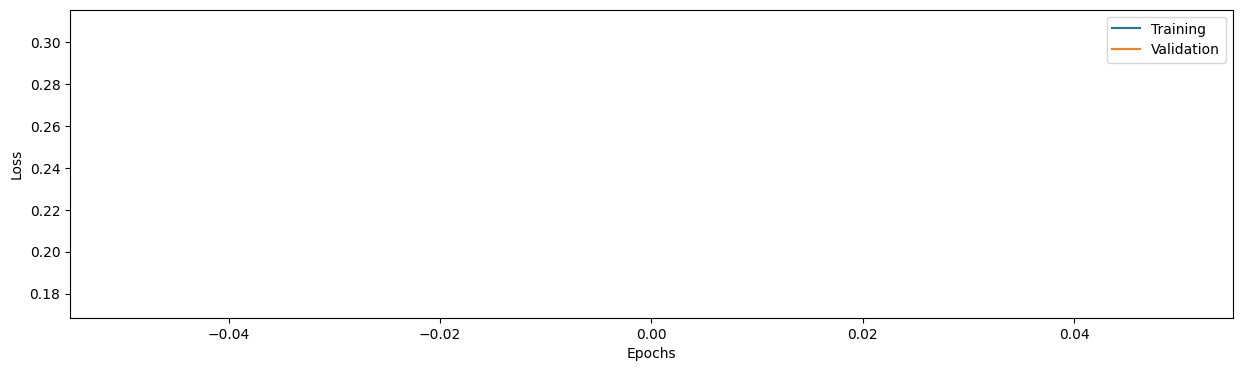

In [ ]:
# save model, scores and plot and check size of model is under 100MB
model_name = "test"

path_name_model = "/content/model_" + model_name+".pt"
path_name_plot = "/content/model_" + model_name + "_losscurve.png"
path_name_scores = "/content/model_" + model_name + "_scores.txt"

torch.save(model.state_dict(), path_name_model)
print(f"Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

import json
with open(path_name_scores, 'w') as file:
     file.write(json.dumps(compute_metrics(all_preds,all_targets)))

Train model on entire training set and compute predictions

Full Model initialized.


  0%|          | 0/1 [00:00<?, ?it/s]


Train Epoch: 0 [0/45918 (0%)]	Loss: 0.715955

Train Epoch: 0 [3200/45918 (7%)]	Loss: 0.222785

Train Epoch: 0 [6400/45918 (14%)]	Loss: 0.190000

Train Epoch: 0 [9600/45918 (21%)]	Loss: 0.199190

Train Epoch: 0 [12800/45918 (28%)]	Loss: 0.220684

Train Epoch: 0 [16000/45918 (35%)]	Loss: 0.198755

Train Epoch: 0 [19200/45918 (42%)]	Loss: 0.178076

Train Epoch: 0 [22400/45918 (49%)]	Loss: 0.217027

Train Epoch: 0 [25600/45918 (56%)]	Loss: 0.203907

Train Epoch: 0 [28800/45918 (63%)]	Loss: 0.220263

Train Epoch: 0 [32000/45918 (70%)]	Loss: 0.207786

Train Epoch: 0 [35200/45918 (77%)]	Loss: 0.225812

Train Epoch: 0 [38400/45918 (84%)]	Loss: 0.193681

Train Epoch: 0 [41600/45918 (91%)]	Loss: 0.216708

Train Epoch: 0 [44800/45918 (97%)]	Loss: 0.160595


100%|██████████| 10000/10000 [00:47<00:00, 209.69it/s]



Predictions computed for test set.


100%|██████████| 10000/10000 [00:46<00:00, 217.13it/s]



Predictions computed for test set.


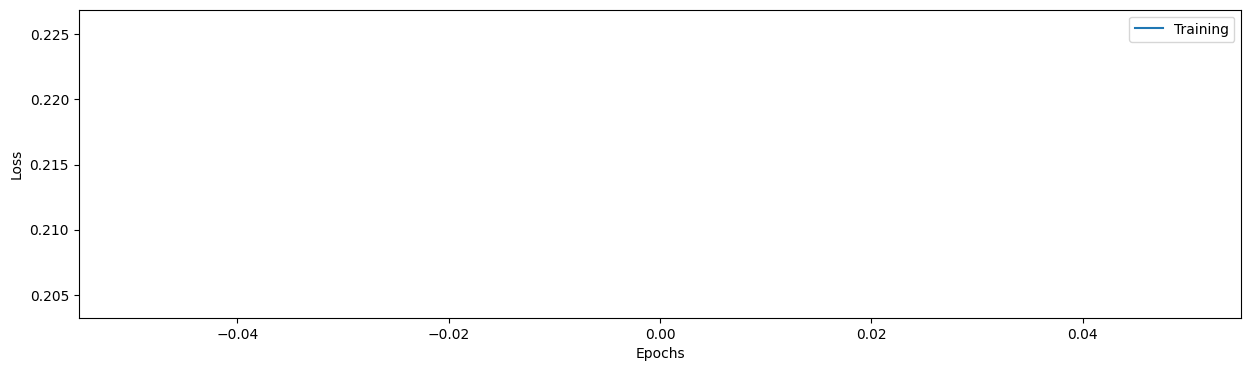

In [52]:
# Training new model on the full dataset
model_full = CNN().to(device)
c_weights_full = c_weights.to(device)
loss_full = torch.nn.BCEWithLogitsLoss() #c_weights_full)
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=lr)
print('Full Model initialized.')
log_interval = 50 # How often we print train loss
train_losses_full = train_network(log_interval,model_full, device, train_dataloader, test_loader=0,optimizer=optimizer_full, loss=loss_full,epochs=1)

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')

# Compute predictions for true test set
thresholds_full = [0.5]*18
test_pred_full = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=True)
test_pred_full_predict_all_false = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=False)

In [ ]:
# Compute predictions for true test set
thresholds_full = [0.5]*18
test_pred_full = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=True)
test_pred_full_predict_all_false = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=False)

100%|██████████| 10000/10000 [00:45<00:00, 221.22it/s]



Predictions computed for test set.


100%|██████████| 10000/10000 [00:45<00:00, 221.08it/s]


Predictions computed for test set.


Save full model, check size and get predictions

Full Model saved to /content/model_24_05_25_two_hidden_full.pt
Full Model size: 3.243013381958008 MB
Submission dataframe:
<bound method NDFrame.describe of         ImageID Labels
0     30000.jpg      1
1     30001.jpg      1
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg      1
...         ...    ...
9995  39995.jpg      1
9996  39996.jpg  1 3 4
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]>
Predictions saved as /content/submission_pred_all_false.csv


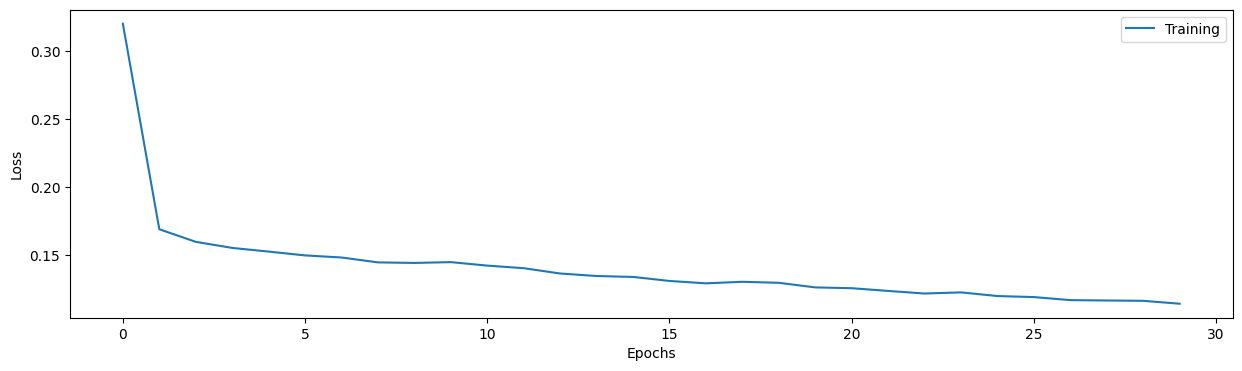

In [ ]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

#test_pred_full = test(model_full, device, test_dataloader,loss,thresholds=thresholds_full,target_available=False)
#print(test_pred_full)

def get_class(array):
  class_pred = np.where(array > 0.5)[1] + 1
  for i in range(len(class_pred)):
    if class_pred[i] >= 12:
      class_pred += 1
  return class_pred

def unencode(y_pred,to_cpu=True):
  labels = []
  for i in range(len(y_pred)):
    if to_cpu: # Move to cpu device
      temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels

# Save full model
path_name_model = "/content/model_" + model_name + "_full.pt"
path_name_plot = "/content/model_" + model_name + "_losscurve_full.png"

torch.save(model_full.state_dict(), path_name_model)
print(f"Full Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Full Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

#Save predictions in csv
pred_labels = unencode(test_pred_full_predict_all_false)
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print("Submission dataframe:")
print(pred_df.describe)
submission_name = "/content/submission.csv"
pred_df.to_csv(submission_name,index=False)
print(f"Predictions saved as {submission_name}")

In [ ]:
# Submit predictions
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission.csv -m "More complex CNN without pred all"

100% 120k/120k [00:00<00:00, 125kB/s]
Successfully submitted to Multi-label Classification Competition 2025